<a href="https://colab.research.google.com/github/rinogrego/komputasi-saintifik/blob/main/Prediksi_Harga_Tutup_Saham_XL_dengan_ARIMA_Model_(Full_Training_dan_Testing_Data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA, ARMAResults, ARIMAResults
from sklearn.metrics import mean_squared_error, mean_absolute_error
try: 
  import yfinance as yf
except:
  !pip install yfinance
  import yfinance as yf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [ ]:
# Import data XL

df = yf.download('EXCL.JK', start='2011-11-23', end='2021-11-22', progress=False)
df.head()
df.reset_index(inplace=True)
df.set_index("Date")

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-11-23,4537.397461,4636.036621,4512.737793,4537.397461,4145.703125,5062902
2011-11-24,4562.057129,4562.057129,4463.418457,4562.057129,4168.233887,1194252
2011-11-25,4512.737793,4685.355957,4512.737793,4512.737793,4123.172852,9806458
2011-11-28,4488.078125,4562.057129,4438.758301,4488.078125,4100.641113,1677834
2011-11-29,4562.057129,4586.717285,4488.078125,4562.057129,4168.233887,5328517
...,...,...,...,...,...,...
2021-11-15,2990.000000,3010.000000,2940.000000,2940.000000,2940.000000,10881400
2021-11-16,2920.000000,2960.000000,2920.000000,2920.000000,2920.000000,16379200
2021-11-17,2950.000000,2950.000000,2880.000000,2930.000000,2930.000000,9186000


In [ ]:
# Mencari Nilai NUll

df[df['Close'].isnull()]

,Date,Open,High,Low,Close,Adj Close,Volume


In [ ]:
# Menghapus nilai null

df = df.dropna()
df[df['Close'].isnull()]

,Date,Open,High,Low,Close,Adj Close,Volume


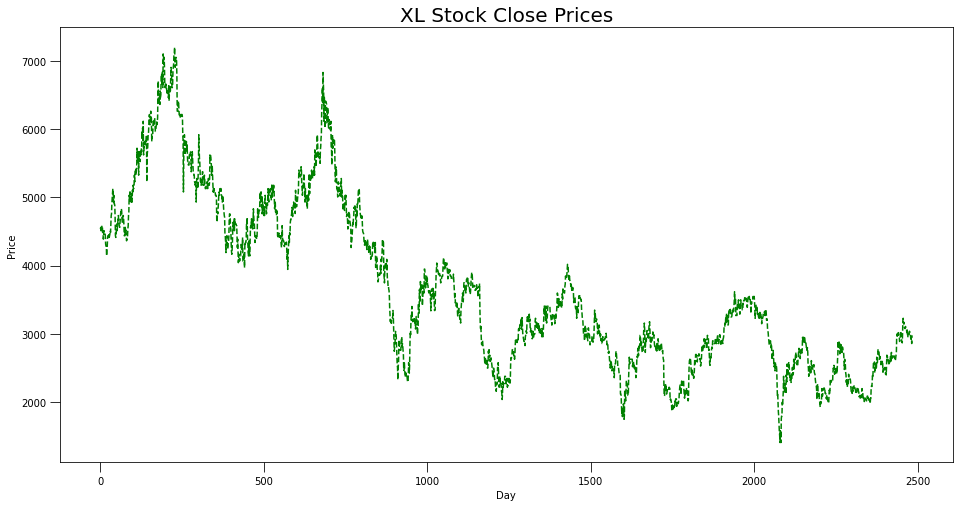

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], 'g--')
plt.title('XL Stock Close Prices', color='black', size=20)
plt.xlabel("Day", color="black", size=10)
plt.ylabel("Price", color="black", size=10)
plt.tick_params(axis='x', colors="black", size=10, labelsize=10)
plt.tick_params(axis='y', colors="black", size=10, labelsize=10)

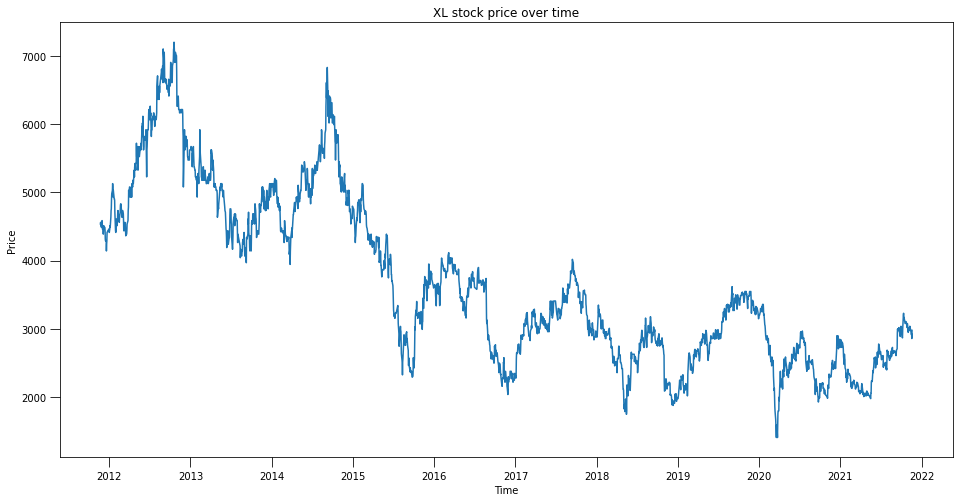

In [ ]:
# PLOT XL STOCK PRICE

RANGE = len(df["Close"])
plt.figure(figsize=(16,8))
plt.plot(df["Date"], df["Close"])
# plt.xticks(np.arange(0, RANGE, 600), df['Date'][0:RANGE:600])
plt.title("XL stock price over time", color="black")
plt.xlabel("Time", color="black", size=10)
plt.ylabel("Price", color="black", size=10)
plt.tick_params(axis='x', colors="black", size=10, labelsize=10)
plt.tick_params(axis='y', colors="black", size=10, labelsize=10)
plt.show()

In [ ]:
import datetime
import time

def run_arima(df, p, d, q, time_point_interval=100, train_split=0.7, plot=False):
  now = time.time()
  if train_split is not None:
    train_data, test_data = df[0:int(len(df)*train_split)], df[int(len(df)*train_split):]
  else:
    train_data, test_data = df[:], df[:]
  training_data = train_data['Close'].values
  test_data = test_data['Close'].values
  history = [x for x in training_data]
  model_predictions = []
  N_test_observations = len(test_data)
  ORDER_P = p
  ORDER_D = d
  ORDER_Q = q
  for time_point in range(N_test_observations):
      if time_point%time_point_interval == 0:
          print("time_point:", time_point) 
      model = ARIMA(history, order=(ORDER_P, ORDER_D, ORDER_Q))
      model_fit = model.fit(disp=0)
      output = model_fit.forecast()
      yhat = output[0]
      model_predictions.append(yhat)
      true_test_value = test_data[time_point]
      history.append(true_test_value)
  MSE_error = mean_squared_error(test_data, model_predictions)
  RMSE_error = mean_squared_error(test_data, model_predictions, squared=False)
  MAE_error = mean_absolute_error(test_data, model_predictions)
  print()
  print('ORDER ({0}, {1}, {2})'.format(ORDER_P, ORDER_D, ORDER_Q))
  print('Testing Mean Squared Error is {}'.format(MSE_error))
  print('Testing Rooted Mean Squared Error is {}'.format(RMSE_error))
  print('Testing Mean Absolute Error is {}'.format(MAE_error))
  time_spent = time.time() - now
  print('Time spent:', time_spent)
  ARIMAResults.summary(model_fit)
  if plot == True:
    plot_arima(df, model_predictions, test_data=test_data, train_split=train_split, p=p, d=d, q=q)
  return ((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent)

def plot_arima(df, model_predictions, test_data, train_split=0.7, p=None, d=None, q=None):
  if p is None or d is None or q is None:
    return "Provide the order: p, d, and q"
  if train_split is not None:
    test_set_range = df[int(len(df)*train_split):].index
  else:
    train_split = 0
    test_set_range = df[:].index
  assert len(model_predictions) == len(test_data)
  assert len(test_data) == len(test_set_range)
  plt.figure(figsize=(20,10))
  plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
  plt.plot(test_set_range, test_data, color='red', label='Actual Price')
  plt.title(f'XL Prices Prediction ({(1-train_split) * 100}% data terakhir; p={p}, d={d}, q={q})', size=20, color="black")
  plt.xlabel("Dates", color="black", size=10)
  plt.ylabel("Prices", color="black", size=10)
  plt.tick_params(axis='x', colors="black", size=10, labelsize=10)
  plt.tick_params(axis='y', colors="black", size=10, labelsize=10)
  # plt.xticks(np.arange(881,RANGE,50), df.Date[881:RANGE:50])
  plt.legend()
  plt.show()

### ORDER (0, 0, 0)

time_point: 0
time_point: 50
time_point: 100
time_point: 150
time_point: 200


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 250
time_point: 300


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 350


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 400
time_point: 450
time_point: 500
time_point: 550


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 600
time_point: 650
time_point: 700

ORDER (0, 0, 0)
Testing Mean Squared Error is 1688946.4583313095
Testing Rooted Mean Squared Error is 1299.5947284947372
Testing Mean Absolute Error is 1214.5952896427832
Time spent: 2.923635959625244


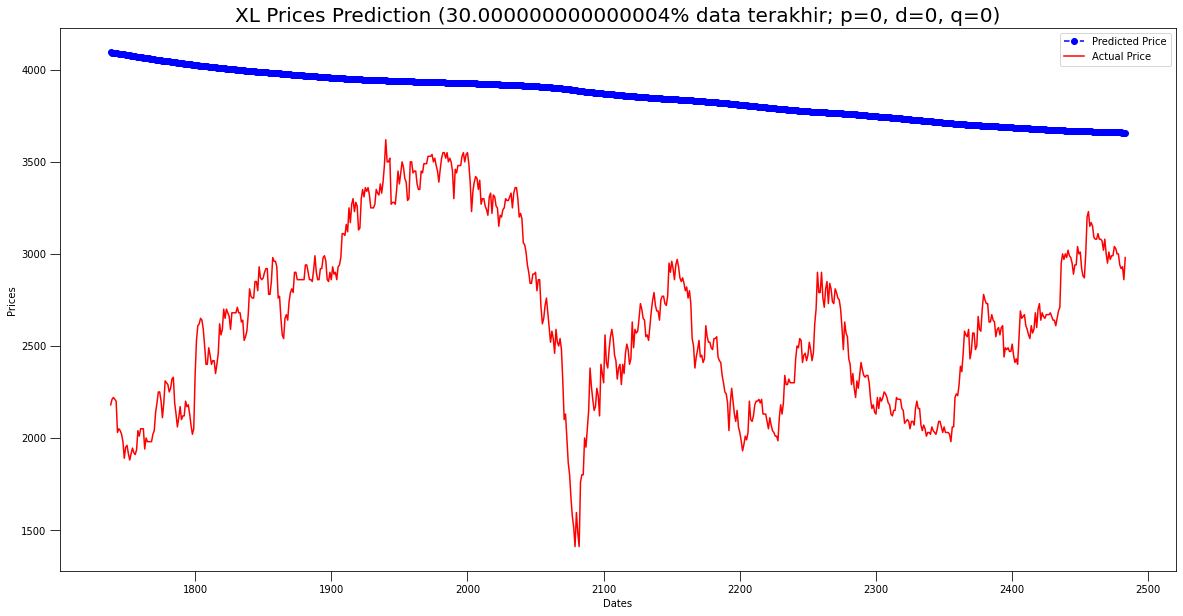

In [ ]:
p = 0
d = 0
q = 0
((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent) = run_arima(df, p, d, q, plot=False, train_split=None)
plot_arima(df, model_predictions, test_data, train_split=0.7, p=p, d=d, q=q)

### ORDER (1, 0, 0)

time_point: 0
time_point: 50


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)


time_point: 100
time_point: 150
time_point: 200
time_point: 250
time_point: 300
time_point: 350


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 400


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 450
time_point: 500
time_point: 550
time_point: 600
time_point: 650
time_point: 700
time_point: 750


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 800
time_point: 850
time_point: 900
time_point: 950
time_point: 1000
time_point: 1050
time_point: 1100
time_point: 1150
time_point: 1200
time_point: 1250
time_point: 1300


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1350
time_point: 1400
time_point: 1450
time_point: 1500


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1550
time_point: 1600
time_point: 1650
time_point: 1700
time_point: 1750


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1800


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1850


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1900
time_point: 1950
time_point: 2000
time_point: 2050


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 2100


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 2150
time_point: 2200
time_point: 2250
time_point: 2300
time_point: 2350
time_point: 2400


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 2450

ORDER (1, 0, 0)
Testing Mean Squared Error is 10771.213736375266
Testing Rooted Mean Squared Error is 103.78445806755107
Testing Mean Absolute Error is 69.96262926759553
Time spent: 234.17185354232788


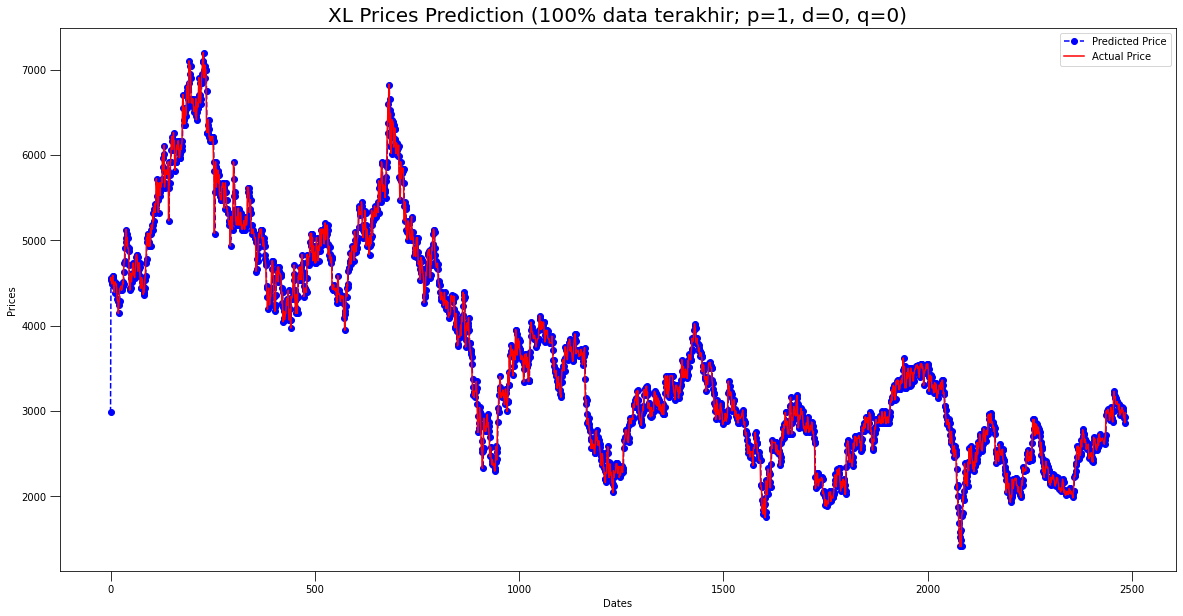

In [ ]:
p = 1
d = 0
q = 0
((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent) = run_arima(df, p, d, q, train_split=None, plot=True)

### ORDER (0, 1, 0)

time_point: 0


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 50
time_point: 100
time_point: 150
time_point: 200


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 250
time_point: 300
time_point: 350
time_point: 400


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 450


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 500
time_point: 550
time_point: 600
time_point: 650
time_point: 700


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 750
time_point: 800


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 850
time_point: 900
time_point: 950
time_point: 1000
time_point: 1050
time_point: 1100
time_point: 1150


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1200
time_point: 1250
time_point: 1300
time_point: 1350


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1400
time_point: 1450
time_point: 1500


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1550
time_point: 1600
time_point: 1650


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1700
time_point: 1750
time_point: 1800
time_point: 1850
time_point: 1900


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1950


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 2000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 2050
time_point: 2100


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 2150
time_point: 2200
time_point: 2250
time_point: 2300


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 2350


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 2400
time_point: 2450


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ORDER (0, 1, 0)
Testing Mean Squared Error is 10786.807259462605
Testing Rooted Mean Squared Error is 103.85955545573361
Testing Mean Absolute Error is 69.4567130729952
Time spent: 13.662161588668823


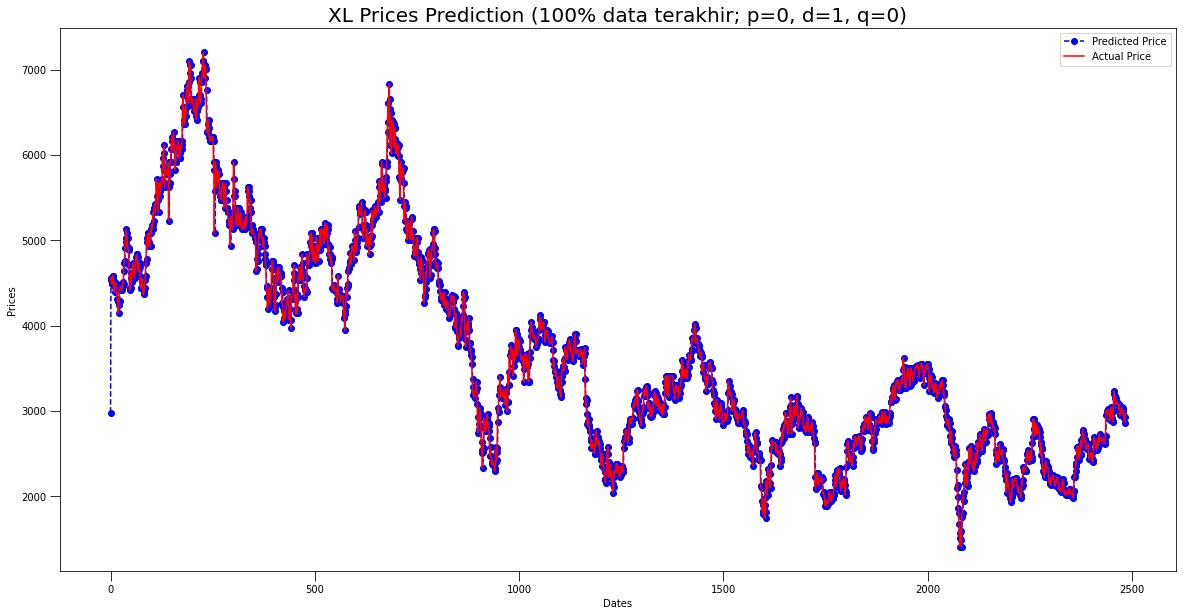

In [ ]:
p = 0
d = 1
q = 0
((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent) = run_arima(df, p, d, q, train_split=None, plot=True)

### ORDER (0, 0, 1)

time_point: 0
time_point: 100
time_point: 200


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 300
time_point: 400
time_point: 500
time_point: 600
time_point: 700
time_point: 800
time_point: 900
time_point: 1000
time_point: 1100
time_point: 1200
time_point: 1300
time_point: 1400
time_point: 1500
time_point: 1600
time_point: 1700
time_point: 1800
time_point: 1900
time_point: 2000
time_point: 2100
time_point: 2200
time_point: 2300
time_point: 2400

ORDER (0, 0, 1)
Testing Mean Squared Error is 423596.6077027387
Testing Rooted Mean Squared Error is 650.8429977365806
Testing Mean Absolute Error is 553.1459850021665
Time spent: 1043.986944437027


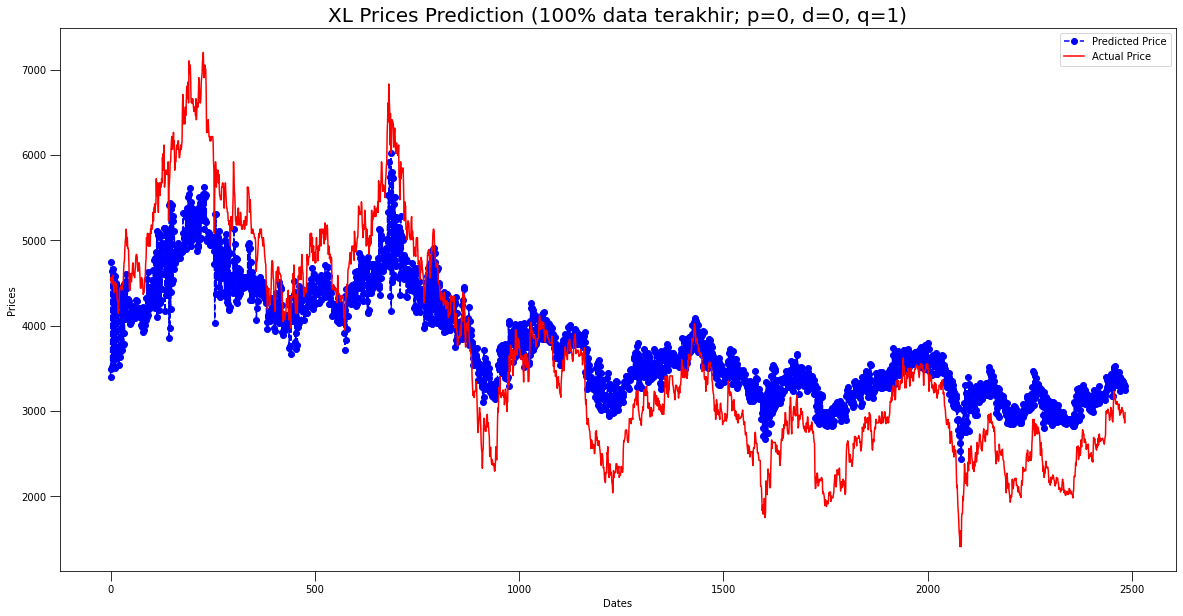

In [ ]:
p = 0
d = 0
q = 1
((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent) = run_arima(df, p, d, q, train_split=None, plot=True)

### ORDER (0, 1, 1)

time_point: 0
time_point: 50
time_point: 100
time_point: 150
time_point: 200


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 250
time_point: 300
time_point: 350
time_point: 400
time_point: 450
time_point: 500
time_point: 550
time_point: 600
time_point: 650
time_point: 700
time_point: 750
time_point: 800
time_point: 850
time_point: 900
time_point: 950
time_point: 1000
time_point: 1050
time_point: 1100
time_point: 1150
time_point: 1200
time_point: 1250
time_point: 1300
time_point: 1350
time_point: 1400
time_point: 1450
time_point: 1500
time_point: 1550
time_point: 1600
time_point: 1650
time_point: 1700
time_point: 1750
time_point: 1800
time_point: 1850
time_point: 1900
time_point: 1950
time_point: 2000
time_point: 2050
time_point: 2100
time_point: 2150
time_point: 2200
time_point: 2250
time_point: 2300
time_point: 2350
time_point: 2400
time_point: 2450

ORDER (0, 1, 1)
Testing Mean Squared Error is 10752.148709079862
Testing Rooted Mean Squared Error is 103.69256824420862
Testing Mean Absolute Error is 69.72579319102759
Time spent: 112.59079170227051


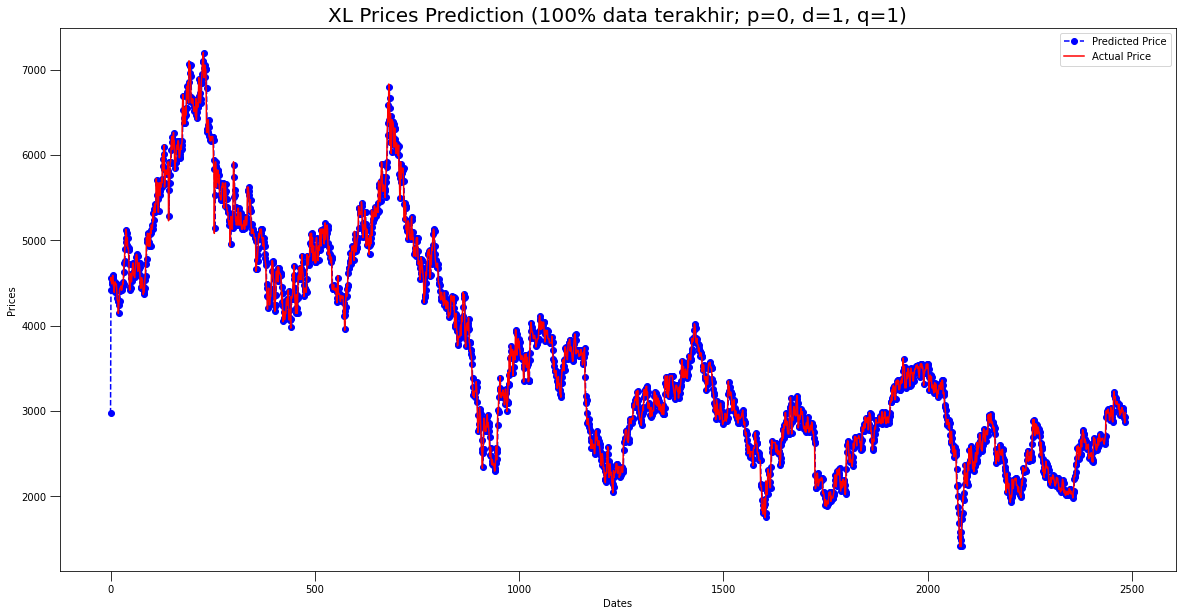

In [ ]:
p = 0
d = 1
q = 1
((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent) = run_arima(df, p, d, q, train_split=None, plot=True)

### ORDER (1, 0, 1)

time_point: 0
time_point: 100


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)


time_point: 200
time_point: 300


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 400
time_point: 500
time_point: 600


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


time_point: 700
time_point: 800
time_point: 900
time_point: 1000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1100


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1200
time_point: 1300
time_point: 1400
time_point: 1500
time_point: 1600
time_point: 1700
time_point: 1800
time_point: 1900
time_point: 2000
time_point: 2100
time_point: 2200
time_point: 2300
time_point: 2400

ORDER (1, 0, 1)
Testing Mean Squared Error is 10738.96595383814
Testing Rooted Mean Squared Error is 103.62898220979564
Testing Mean Absolute Error is 69.9533236261721
Time spent: 1617.7254433631897


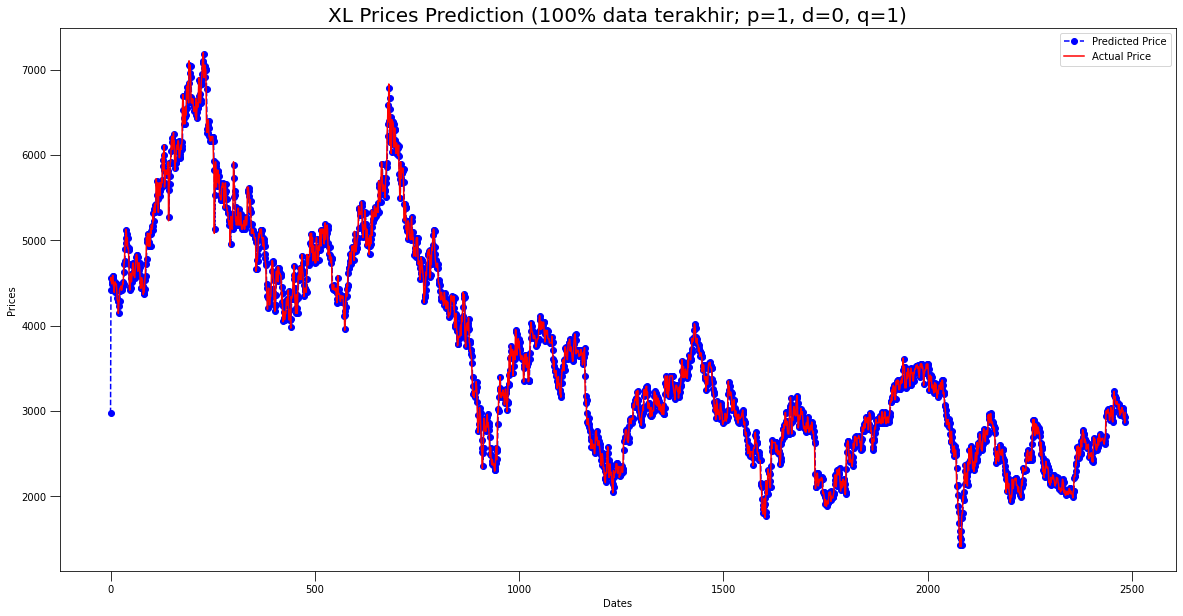

In [ ]:
p = 1
d = 0
q = 1
((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent) = run_arima(df, p, d, q, train_split=None, plot=True)

### ORDER (1, 1, 0)

time_point: 0
time_point: 50
time_point: 100
time_point: 150
time_point: 200
time_point: 250
time_point: 300
time_point: 350
time_point: 400
time_point: 450
time_point: 500
time_point: 550
time_point: 600
time_point: 650
time_point: 700
time_point: 750
time_point: 800
time_point: 850
time_point: 900
time_point: 950
time_point: 1000
time_point: 1050
time_point: 1100
time_point: 1150
time_point: 1200
time_point: 1250
time_point: 1300
time_point: 1350
time_point: 1400
time_point: 1450
time_point: 1500
time_point: 1550
time_point: 1600
time_point: 1650
time_point: 1700
time_point: 1750
time_point: 1800
time_point: 1850
time_point: 1900
time_point: 1950
time_point: 2000
time_point: 2050
time_point: 2100
time_point: 2150
time_point: 2200
time_point: 2250
time_point: 2300
time_point: 2350
time_point: 2400
time_point: 2450

ORDER (1, 1, 0)
Testing Mean Squared Error is 10754.285159704843
Testing Rooted Mean Squared Error is 103.70286958278851
Testing Mean Absolute Error is 69.73777954867681
Ti

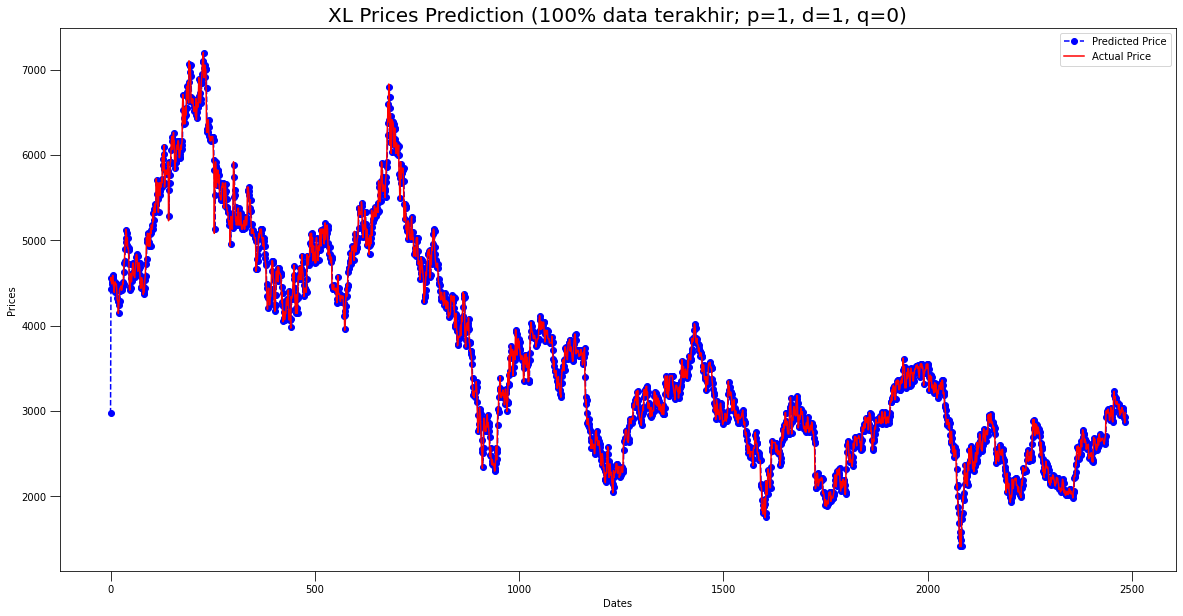

In [ ]:
p = 1
d = 1
q = 0
((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent) = run_arima(df, p, d, q, train_split=None, plot=True)

### ORDER (1, 1, 1)

time_point: 0
time_point: 50
time_point: 100
time_point: 150
time_point: 200
time_point: 250
time_point: 300
time_point: 350
time_point: 400
time_point: 450
time_point: 500
time_point: 550
time_point: 600
time_point: 650
time_point: 700
time_point: 750
time_point: 800
time_point: 850
time_point: 900
time_point: 950
time_point: 1000
time_point: 1050


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1100
time_point: 1150
time_point: 1200
time_point: 1250
time_point: 1300
time_point: 1350
time_point: 1400
time_point: 1450
time_point: 1500
time_point: 1550
time_point: 1600
time_point: 1650
time_point: 1700
time_point: 1750
time_point: 1800
time_point: 1850
time_point: 1900
time_point: 1950
time_point: 2000
time_point: 2050
time_point: 2100
time_point: 2150
time_point: 2200
time_point: 2250
time_point: 2300
time_point: 2350
time_point: 2400
time_point: 2450

ORDER (1, 1, 1)
Testing Mean Squared Error is 10737.793216606053
Testing Rooted Mean Squared Error is 103.62332370951076
Testing Mean Absolute Error is 69.6403376916345
Time spent: 1622.6707382202148


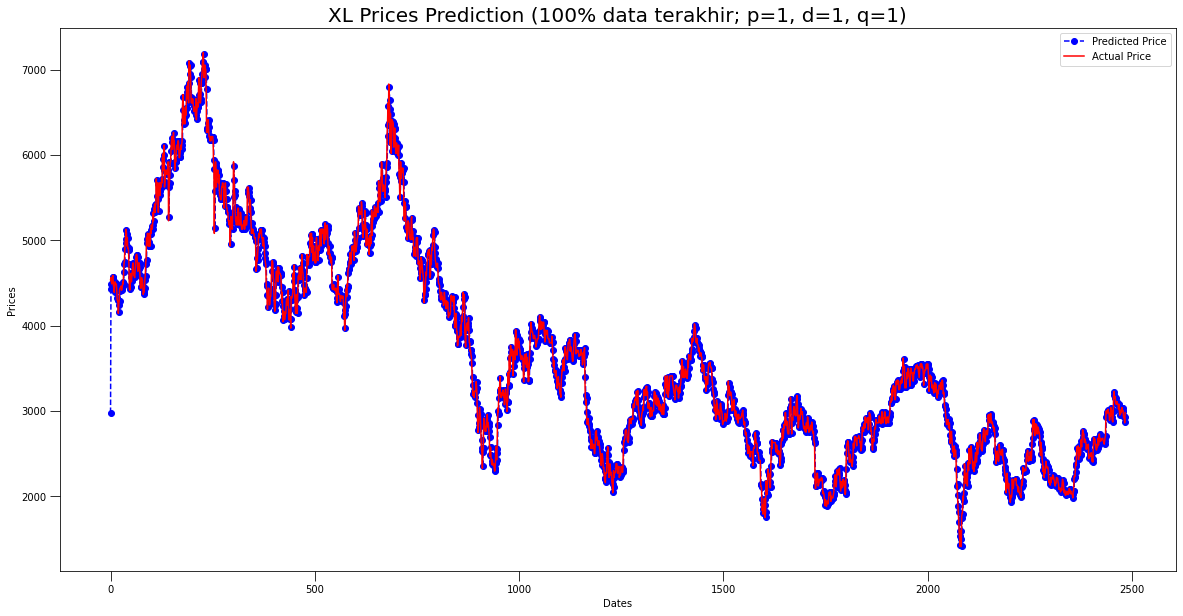

In [ ]:
p = 1
d = 1
q = 1
((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent) = run_arima(df, p, d, q, train_split=None, plot=True)

### ORDER (1, 0, 2)

time_point: 0
time_point: 100
time_point: 200


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


time_point: 300
time_point: 400
time_point: 500
time_point: 600
time_point: 700
time_point: 800
time_point: 900
time_point: 1000
time_point: 1100
time_point: 1200
time_point: 1300
time_point: 1400
time_point: 1500
time_point: 1600
time_point: 1700
time_point: 1800
time_point: 1900
time_point: 2000
time_point: 2100
time_point: 2200
time_point: 2300
time_point: 2400

ORDER (1, 0, 2)
Testing Mean Squared Error is 10736.341005541584
Testing Rooted Mean Squared Error is 103.61631630945767
Testing Mean Absolute Error is 69.8771550166645
Time spent: 1781.9507122039795


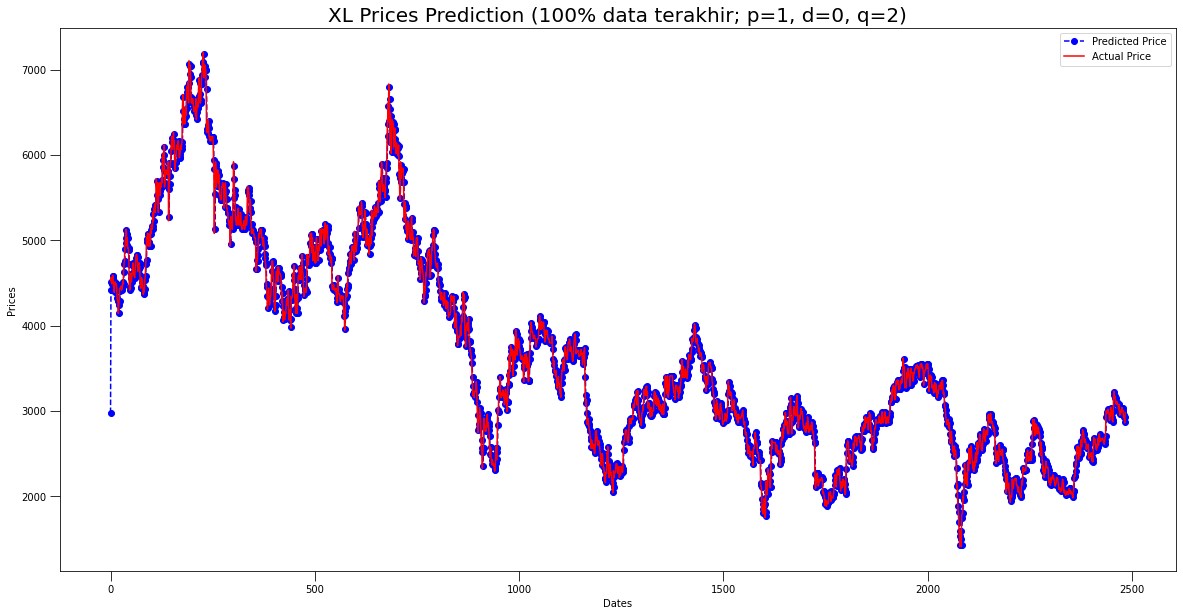

In [ ]:
p = 1
d = 0
q = 2
((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent) = run_arima(df, p, d, q, train_split=None, plot=True, time_point_interval=100)

### ORDER (2, 0, 0)

time_point: 0
time_point: 100
time_point: 200
time_point: 300
time_point: 400
time_point: 500
time_point: 600
time_point: 700
time_point: 800
time_point: 900
time_point: 1000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1100


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


time_point: 1200
time_point: 1300
time_point: 1400
time_point: 1500
time_point: 1600
time_point: 1700
time_point: 1800
time_point: 1900
time_point: 2000
time_point: 2100
time_point: 2200
time_point: 2300
time_point: 2400

ORDER (2, 0, 0)
Testing Mean Squared Error is 10741.084514201208
Testing Rooted Mean Squared Error is 103.63920355831189
Testing Mean Absolute Error is 69.96428326340799
Time spent: 719.8107869625092


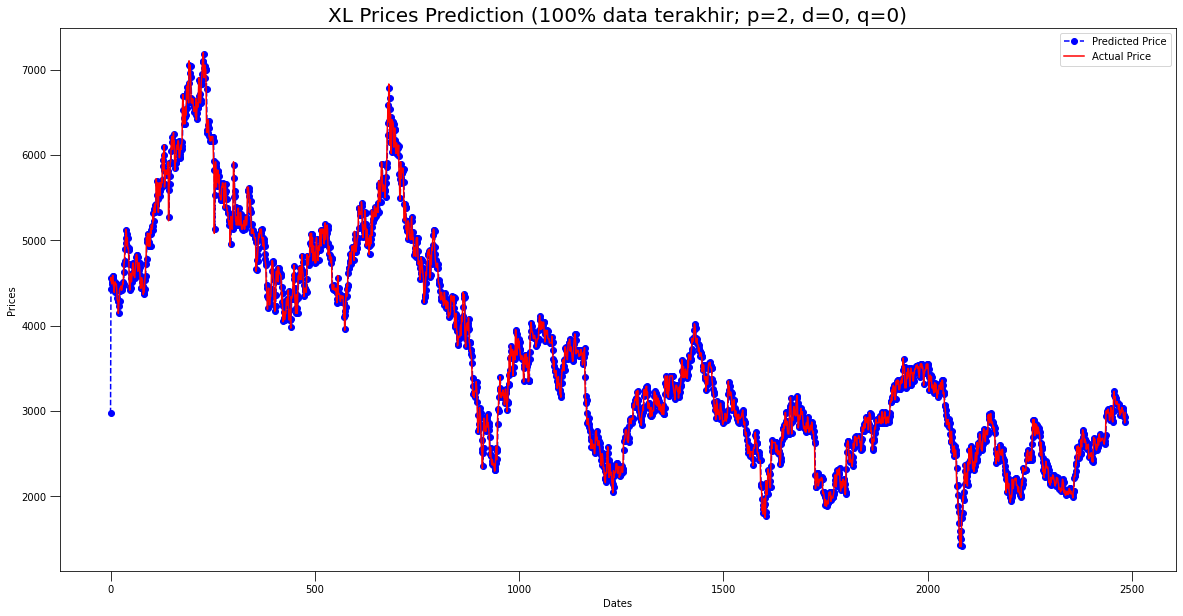

In [ ]:
p = 2
d = 0
q = 0
((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent) = run_arima(df, p, d, q, train_split=None, plot=True, time_point_interval=100)

### ORDER (2, 0, 1)

In [ ]:
p = 2
d = 0
q = 1
((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent) = run_arima(df, p, d, q, train_split=None, plot=True, time_point_interval=100)

time_point: 0


ValueError: ignored

### ORDER (2, 0, 2)

In [ ]:
p = 2
d = 0
q = 2
((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent) = run_arima(df, p, d, q, train_split=None, plot=True, time_point_interval=100)

time_point: 0


ValueError: ignored

### ORDER (2, 1, 2)

In [ ]:
p = 2
d = 1
q = 2
((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent) = run_arima(df, p, d, q, train_split=None, plot=True, time_point_interval=100)

time_point: 0


ValueError: ignored

### ORDER (2, 2, 2)

In [ ]:
p = 2
d = 2
q = 2
((p, d, q), (MSE_error, RMSE_error, MAE_error), test_data, model_predictions, time_spent) = run_arima(df, p, d, q, train_split=None, plot=True, time_point_interval=100)

time_point: 0


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lo

time_point: 100


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist

time_point: 200


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/s

time_point: 300


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/pyt

time_point: 400


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/pyt

time_point: 500


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/lo

time_point: 600


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/lo

time_point: 700


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/pyt

time_point: 800


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/pyt

time_point: 900


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/pyt

time_point: 1000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarni

time_point: 1100


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/pyt

ValueError: ignored

### Pengecekan Pengaruh Outlier Data Awal Terhadap RMSE

time_point: 0
time_point: 100
time_point: 200


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


time_point: 300
time_point: 400
time_point: 500
time_point: 600
time_point: 700
time_point: 800
time_point: 900
time_point: 1000
time_point: 1100
time_point: 1200
time_point: 1300
time_point: 1400
time_point: 1500
time_point: 1600
time_point: 1700
time_point: 1800
time_point: 1900
time_point: 2000
time_point: 2100
time_point: 2200
time_point: 2300
time_point: 2400

ORDER (1, 0, 2)
Testing Mean Squared Error is 10736.341005541584
Testing Rooted Mean Squared Error is 103.61631630945767
Testing Mean Absolute Error is 69.8771550166645
Time spent: 1920.0961418151855


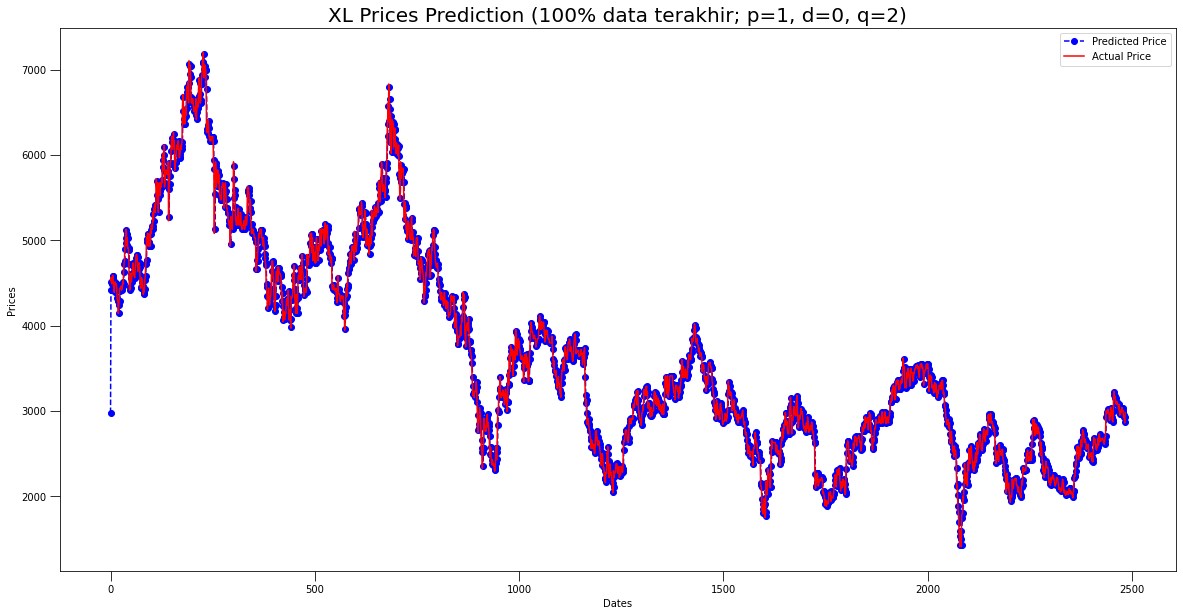

In [ ]:
p = 1
d = 0
q = 2
((p, d, q), (MSE_error_test, RMSE_error_test, MAE_error_test), test_data_test, model_predictions_test, time_spent_test) = run_arima(df, p, d, q, train_split=None, plot=True, time_point_interval=100)

In [ ]:
x = test_data_test[:]
y = model_predictions_test[:]
print('RMSE semua data                       :', mean_squared_error(x, y, squared=False))
print('RMSE tanpa outlier                    :', mean_squared_error(x[1:], y[1:], squared=False))
print('RMSE 10 data pertama                  :', mean_squared_error(x[:10], y[:10], squared=False))
print('RMSE 9 data pertama setelah outlier   :', mean_squared_error(x[1:10], y[1:10], squared=False))
print(np.array(x[1:10]).tolist())
print(np.array(y[1:10]).tolist())

RMSE semua data                       : 103.61631630945767
RMSE tanpa outlier                    : 98.77771768511636
RMSE 10 data pertama                  : 498.9662409132897
RMSE 9 data pertama setelah outlier   : 72.51526885889619
[4562.05712890625, 4512.73779296875, 4488.078125, 4562.05712890625, 4586.71728515625, 4586.71728515625, 4463.41845703125, 4463.41845703125, 4389.43896484375]
[[4419.42473676918], [4510.053979502585], [4507.105011886092], [4487.120552606056], [4555.456383448338], [4579.830024632403], [4582.876953738442], [4468.663798571796], [4464.771152844182]]


### References
[Time-Series Forecasting: Predicting Stock Prices Using An ARIMA Model](https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70)

[Download Financial Dataset Using Yahoo Finance in Python | A Complete Guide](https://www.analyticsvidhya.com/blog/2021/06/download-financial-dataset-using-yahoo-finance-in-python-a-complete-guide/)

### Previous Notebook
[Prediksi Harga Tutup Saham XL dengan ARIMA Model](https://colab.research.google.com/drive/1FhfuZqr4HhYevRa6cG4K6SpN_56vtMZ3?usp=sharing)

